In [2]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import sys


sys.path.insert(1, '../g3m_utils/')
from state_evolution.data_models.custom import Custom,CustomSpectra
from state_evolution.experiments.learning_curve import CustomExperiment
import pandas as pd
from scipy.special import erf
import pickle

In [16]:
d=200
k=200
kt=200

In [17]:
Sigma=np.ones(d) #covariance matrix of data

In [18]:
activ="erf"

f1=lambda x: erf(x)
f2=lambda x: f1(x)#erf(x)

r_1=np.mean(Sigma)

k1_1=quad(lambda x: np.exp(-.5*x**2/r_1)*x*f1(x)/np.sqrt(2*np.pi*r_1),-np.inf,np.inf)[0]/r_1
var_1=quad(lambda x: np.exp(-.5*x**2/r_1)*f1(x)**2/np.sqrt(2*np.pi*r_1),-np.inf,np.inf)[0]
ks_1=np.sqrt(var_1-r_1*k1_1**2)

r_2=var_1
k1_2=quad(lambda x: np.exp(-.5*x**2/r_2)*x*f2(x)/np.sqrt(2*np.pi*r_2),-np.inf,np.inf)[0]/r_2
var_2=quad(lambda x: np.exp(-.5*x**2/r_2)*f2(x)**2/np.sqrt(2*np.pi*r_2),-np.inf,np.inf)[0]
ks_2=np.sqrt(var_2-r_2*k1_2**2)

print("var1={} var2={}".format(var_1,var_2))

var1=0.46455905439753986 var2=0.31990900968062896


In [19]:
teacher_activ="id"

ft=lambda x:  x#erf(x)

rt=np.mean(Sigma)

k1_t=quad(lambda x: np.exp(-.5*x**2/rt)*x*ft(x)/np.sqrt(2*np.pi*rt),-np.inf,np.inf)[0]/rt
var_t=quad(lambda x: np.exp(-.5*x**2/rt)*ft(x)**2/np.sqrt(2*np.pi*rt),-np.inf,np.inf)[0]
ks_t=np.sqrt(np.maximum(var_t-rt*k1_t**2,0))

In [20]:
print("teacher r={} k1={} ks={}\n".format(rt,k1_t,ks_t))
print("layer #1 r={} k1={} ks={}\n".format(r_1,k1_1,ks_1))
print("layer #2 r={} k1={} ks={}".format(r_2,k1_2,ks_2))

teacher r=1.0 k1=1.000000000000001 ks=0.0

layer #1 r=1.0 k1=0.6514700158705591 ks=0.20036435017026702

layer #2 r=0.46455905439753986 k1=0.8124107293490346 ks=0.11530322586017638


In [21]:
theta=np.random.randn(kt)/np.sqrt(kt)
Wt=np.random.randn(kt,d)/np.sqrt(d)

if teacher_activ=="id":
    kt=d
    theta=np.random.randn(kt)/np.sqrt(kt)
    Wt=np.eye(d)
    


#student matrices
W1=np.random.randn(k,d)/np.sqrt(d)
W2=np.random.randn(k,k)/np.sqrt(k)

In [22]:


Omega=k1_2**2*k1_1**2*(W2@W1@np.diag(Sigma)@W1.T@W2.T)+k1_2**2*ks_1**2*W2@W2.T+ks_2**2*np.eye(k)  

In [23]:
Phi=k1_1*k1_2*k1_t*W2@W1@np.diag(Sigma)@Wt.T


In [24]:
Psi=k1_t**2*Wt@np.diag(Sigma)@Wt.T+ks_t**2*np.eye(kt)


In [25]:
def replica(alphas,Psi,Omega, Phi,lamb=0.1,verbose=False):   
    
    data_model=Custom(
                     teacher_teacher_cov=Psi,
                     student_student_cov=Omega,
                     teacher_student_cov=Phi,
                     teacher=theta.flatten()*np.sqrt(kt),
                     fixed_teacher=True)
    experiment = CustomExperiment(task = 'logistic_regression', 
                                  regularisation = lamb, 
                                  data_model = data_model, 
                                  tolerance = 1e-7, 
                                  damping = 0.2, 
                                  verbose = verbose, 
                                  max_steps = 10000)
    experiment.learning_curve(alphas =[alphas[0]])
    replicas=experiment.get_curve()


    for i in range(1,len(alphas)):
        print("sample",alphas[i])
        print(replicas["test_error"])
        
        experiment.learning_curve(alphas =[alphas[i]])
        replicas=pd.concat([replicas,experiment.get_curve()])
        

    
    return replicas

In [26]:
alphas=np.linspace(0.1,3,5)*d/k

In [27]:
lamb=0.05

In [28]:
repl=replica(alphas,Psi,Omega, Phi,lamb=lamb)

sample 0.825
0    0.465575
Name: test_error, dtype: float64
sample 1.55
0    0.465575
0    0.388998
Name: test_error, dtype: float64
sample 2.275
0    0.465575
0    0.388998
0    0.348146
Name: test_error, dtype: float64
sample 3.0
0    0.465575
0    0.388998
0    0.348146
0    0.322823
Name: test_error, dtype: float64


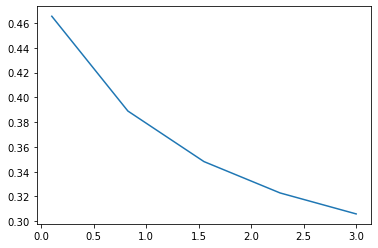

In [29]:
plt.plot(repl["sample_complexity"],repl["test_error"])